In [2]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

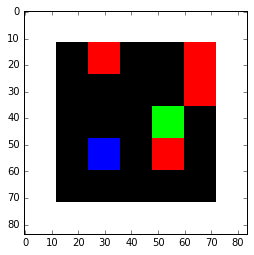

In [3]:
from gridworld_v02 import gameEnv
env = gameEnv(partial=False, size=5)

In [10]:
class Qnetwork():
    def __init__(self, h_size, name = "main"): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutinoal layers.
        self.net_name = name
        self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        self.conv1 = slim.conv2d(inputs=self.imageIn,
                                 num_outputs=32,
                                 kernel_size=[8,8],
                                 stride=[4,4],
                                 padding='VALID', 
                                 biases_initializer = None)
        
        self.conv2 = slim.conv2d(inputs=self.conv1,
                                 num_outputs=64,
                                 kernel_size=[4,4],
                                 stride=[2,2],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv3 = slim.conv2d(inputs=self.conv2,
                                 num_outputs=64,
                                 kernel_size=[3,3],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv4 = slim.conv2d(inputs=self.conv3,
                                 num_outputs=h_size,
                                 kernel_size=[7,7],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        
        print(self.conv4.shape)
        
        #We take the output from the final convolutional layer and split it into separated terms: advantage & value
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        print(self.streamAC.shape)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        self.AW = tf.Variable(xavier_init([h_size//2, env.actions]))
        self.VM = tf.Variable(xavier_init([h_size//2, 1]))
        
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VM)
        
        #Then combine to obtain the final Q-value //why substract mean from Advantage?
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)    
    

In [11]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [12]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [13]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [14]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [15]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 10 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 10000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 3*10000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 10000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 50

load_model = False #Wheter to load a saved model
path = "./dqn_logs_sh3" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [16]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

(?, 1, 1, 512)
(?, 1, 1, 256)
(?, 1, 1, 512)
(?, 1, 1, 256)


In [17]:
def replay_train(trainBatch):
    #print("traingBatch shape" + str(trainBatch.shape))

    #Perform the Double-DQN update to the target Q-values
    Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
    #print("Q1" + str(np.vstack(trainBatch[:,3])))

    Q2 = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
    end_multiplier = -(trainBatch[:,4]-1)
    #print("Q2" + str(Q2))

    doubleQ = Q2[range(batch_size), Q1]
    targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)

    #Update the network with our target values
    return sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.targetQ:targetQ,
                          mainQN.actions:trainBatch[:,1]})


In [19]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        print(s)
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Saved Model
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]



[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]

=====Episode 100start =====
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]


[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]

=====Episode 200start =====
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]


KeyboardInterrupt: 

In [ ]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [53]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [54]:
sess = tf.InteractiveSession()

In [55]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs_sh3/model-29999.cptk


[2017-06-05 05:12:14,119] Restoring parameters from ./dqn_logs_sh3/model-29999.cptk


In [56]:
#Reset environment and get the first new observation
s = env.reset()
s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 2
Reward: 0 , Done: False


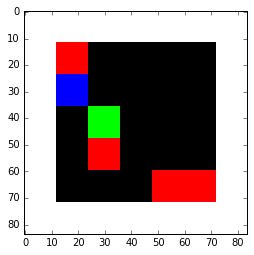

In [145]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [30]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [51]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn_logs_sh3/model-29999.cptk


[2017-06-05 03:50:36,396] Restoring parameters from ./dqn_logs_sh3/model-29999.cptk


87	0.9
308	0.6
395	0.9
613	0.6
742	0.8
918	0.7
1096	0.7
1317	0.6
1447	0.8
1581	0.8
1616	1.0
1645	1.0
1675	1.0
1803	0.8
1924	0.8
2005	0.9
2181	0.7
2319	0.8
2489	0.7
2666	0.7
2791	0.8
2965	0.7
3230	0.5
3350	0.8
3422	0.9
3551	0.8
3913	0.3
4039	0.8
4121	0.9
4250	0.8
4379	0.8
4553	0.7
4681	0.8
4811	0.8
5039	0.6
5170	0.8
5385	0.6
5610	0.6
5736	0.8
5810	0.9
5891	0.9
6154	0.5
6416	0.5
6545	0.8
6765	0.6
6935	0.7
7070	0.8
7429	0.3
7602	0.7
7737	0.8
7866	0.8
8041	0.7
8213	0.7
8393	0.7
8611	0.6
8636	1.0
8764	0.8
8931	0.7
9107	0.7
9228	0.8
9541	0.4
9670	0.8
9790	0.8
10109	0.4
10180	0.9
10250	0.9
10425	0.7
10598	0.7
10770	0.7
10896	0.8
11024	0.8
11058	1.0
11133	0.9
11307	0.7
11386	0.9
11597	0.6
11819	0.6
11955	0.8
12175	0.6
12441	0.5
12661	0.6
12934	0.5
13105	0.7
13321	0.6
13452	0.8
13488	1.0
13713	0.6
13830	0.8
14004	0.7
14176	0.7
14304	0.8
14474	0.7
14646	0.7
14872	0.6
15050	0.7
15081	1.0
15254	0.7
15518	0.5
15640	0.8
15766	0.8
15935	0.7
16104	0.7
16234	0.8
16457	0.6
16678	0.6
16799	0.8
16926	0.8


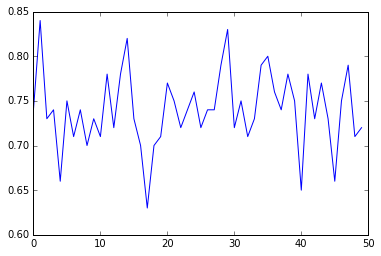

In [52]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

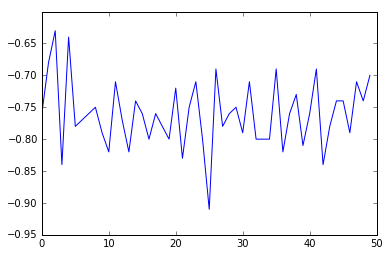

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)